In [16]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

from flows import RealNVP, Planar
from models import NormalizingFlowModel

## Load and process the data

In [17]:
f_PureBkg = pd.read_hdf("/data/t3home000/spark/LHCOlympics/data/MassRatio_pureBkg.h5")
dt_PureBkg = f_PureBkg.values

In [18]:
dt_PureBkg[:,1] = (dt_PureBkg[:,1]-np.mean(dt_PureBkg[:,1]))/np.std(dt_PureBkg[:,1])
dt_PureBkg[:,2] = (dt_PureBkg[:,2]-np.mean(dt_PureBkg[:,2]))/np.std(dt_PureBkg[:,2])
dt_PureBkg[:,3] = (dt_PureBkg[:,3]-np.mean(dt_PureBkg[:,3]))/np.std(dt_PureBkg[:,3])
dt_PureBkg[:,4] = (dt_PureBkg[:,4]-np.mean(dt_PureBkg[:,4]))/np.std(dt_PureBkg[:,4])
dt_PureBkg[:,5] = (dt_PureBkg[:,5]-np.mean(dt_PureBkg[:,5]))/np.std(dt_PureBkg[:,5])
dt_PureBkg[:,6] = (dt_PureBkg[:,6]-np.mean(dt_PureBkg[:,6]))/np.std(dt_PureBkg[:,6])


dt_PureBkg[:,8] = (dt_PureBkg[:,8]-np.mean(dt_PureBkg[:,8]))/np.std(dt_PureBkg[:,8])
dt_PureBkg[:,9] = (dt_PureBkg[:,9]-np.mean(dt_PureBkg[:,9]))/np.std(dt_PureBkg[:,9])
dt_PureBkg[:,10] = (dt_PureBkg[:,10]-np.mean(dt_PureBkg[:,10]))/np.std(dt_PureBkg[:,10])
dt_PureBkg[:,11] = (dt_PureBkg[:,11]-np.mean(dt_PureBkg[:,11]))/np.std(dt_PureBkg[:,11])
dt_PureBkg[:,12] = (dt_PureBkg[:,12]-np.mean(dt_PureBkg[:,12]))/np.std(dt_PureBkg[:,12])

dt_PureBkg[:,14] = (dt_PureBkg[:,14]-np.mean(dt_PureBkg[:,14]))/np.std(dt_PureBkg[:,14])
dt_PureBkg[:,15] = (dt_PureBkg[:,15]-np.mean(dt_PureBkg[:,15]))/np.std(dt_PureBkg[:,15])
dt_PureBkg[:,16] = (dt_PureBkg[:,16]-np.mean(dt_PureBkg[:,16]))/np.std(dt_PureBkg[:,16])
dt_PureBkg[:,17] = (dt_PureBkg[:,17]-np.mean(dt_PureBkg[:,17]))/np.std(dt_PureBkg[:,17])
dt_PureBkg[:,18] = (dt_PureBkg[:,18]-np.mean(dt_PureBkg[:,18]))/np.std(dt_PureBkg[:,18])
dt_PureBkg[:,19] = (dt_PureBkg[:,19]-np.mean(dt_PureBkg[:,19]))/np.std(dt_PureBkg[:,19])


dt_PureBkg[:,21] = (dt_PureBkg[:,21]-np.mean(dt_PureBkg[:,21]))/np.std(dt_PureBkg[:,21])
dt_PureBkg[:,22] = (dt_PureBkg[:,22]-np.mean(dt_PureBkg[:,22]))/np.std(dt_PureBkg[:,22])
dt_PureBkg[:,23] = (dt_PureBkg[:,23]-np.mean(dt_PureBkg[:,23]))/np.std(dt_PureBkg[:,23])
dt_PureBkg[:,24] = (dt_PureBkg[:,24]-np.mean(dt_PureBkg[:,24]))/np.std(dt_PureBkg[:,24])
dt_PureBkg[:,25] = (dt_PureBkg[:,25]-np.mean(dt_PureBkg[:,25]))/np.std(dt_PureBkg[:,25])

In [19]:
total_PureBkg = torch.tensor(dt_PureBkg)
total_PureBkg_train_x_1 = total_PureBkg.t()[1:7].t()
total_PureBkg_train_x_2 = total_PureBkg.t()[8:13].t()
total_PureBkg_train_x_3 = total_PureBkg.t()[14:20].t()
total_PureBkg_train_x_4 = total_PureBkg.t()[21:26].t()

total_PureBkg_selection = torch.cat((total_PureBkg_train_x_1,total_PureBkg_train_x_2,total_PureBkg_train_x_3,total_PureBkg_train_x_4),dim=1)

In [20]:
bs = 1000
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [21]:
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(22, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 22),
            nn.Sigmoid()
        )
        
        flow_init = Planar(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [22]:
N_EPOCHS = 10
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 2
Z_DIM = 3

n_steps = 0

In [11]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [12]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [13]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss = loss_recons + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [14]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss = loss_recons + kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [23]:
BEST_LOSS = 99999
LAST_SAVED = -1
for epoch in range(1, N_EPOCHS):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar.h5")
    else:
        print("Not saving model! Last saved: {}".format(LAST_SAVED))

Epoch 1:

Evaluation Completed (valid)!	Loss: -382.0795 Time: 3.209 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -384.5019 Time: 3.204 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -384.2560 Time: 3.210 s
Not saving model! Last saved: 2
Epoch 4:

Evaluation Completed (valid)!	Loss: -384.5752 Time: 3.209 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -383.5045 Time: 3.212 s
Not saving model! Last saved: 4
Epoch 6:

Evaluation Completed (valid)!	Loss: -383.1235 Time: 3.984 s
Not saving model! Last saved: 4
Epoch 7:

Evaluation Completed (valid)!	Loss: -381.4383 Time: 3.190 s
Not saving model! Last saved: 4
Epoch 8:

Evaluation Completed (valid)!	Loss: -381.2356 Time: 3.298 s
Not saving model! Last saved: 4
Epoch 9:

Evaluation Completed (valid)!	Loss: -379.9078 Time: 3.266 s
Not saving model! Last saved: 4


## Testing with the trained model

In [ ]:
def get_mass_and_loss(inputstring):
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])


    
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    
    with torch.no_grad():
        loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]-
                       total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0], dt_in[:,10], dt_in[:,23], dt_in[:,9], dt_in[:,22], loss_total_in

In [ ]:
def get_mass(inputstring):

    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0]

In [ ]:
bb2mass = get_mass("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_BB1.h5")
purebkgmass = get_mass("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_pureBkg.h5")

In [ ]:
bb2mass, bb2mmdt1, bb2mmdt2, bb2prun1,bb2prun2, bb2loss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_BB1.h5")
purebkgmass, purebkgmmdt1, purebkgmmdt2, purebkgprun1,purebkgprun2, purebkgloss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_pureBkg.h5")

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,5,1100)
plt.hist(bb2loss,bins=bins,alpha=0.3,color='b',label='blackbox1')
plt.hist(purebkgloss,bins=bins,alpha=0.3,color='r',label='background')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [ ]:
f = pd.read_hdf("Nsubjettiness_mjj.h5")
dt = f.values
idx = dt[:,15]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]
data_bkg = torch.tensor(dt[bkg_idx])
data_signal = torch.tensor(dt[signal_idx])
data_train_x_1 = data_bkg.t()[0:6].t()
data_train_x_2 = data_bkg.t()[7:13].t()
data_test_bkg = torch.cat((data_train_x_1,data_train_x_2),dim=1)
data_train_x_1 = data_signal.t()[0:6].t()
data_train_x_2 = data_signal.t()[7:13].t()
data_test_signal = torch.cat((data_train_x_1,data_train_x_2),dim=1)

In [ ]:
loss_bkg = torch.mean((model(data_test_bkg.float().cuda())[0]-data_test_bkg.float().cuda())**2,dim=1).data.cpu().numpy()


In [ ]:
loss_sig = torch.mean((model(data_test_signal.float().cuda())[0]-data_test_signal.float().cuda())**2,dim=1).data.cpu().numpy()


In [24]:
def get_loss(dt_in):

    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])   
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    
    with torch.no_grad():
        loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    return loss_total_in

In [25]:
f = pd.read_hdf("/data/t3home000/spark/LHCOlympics/data/MassRatio_RandD.h5")
dt = f.values

In [26]:
idx = dt[:,27]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [27]:
loss_bkg = get_loss(dt[bkg_idx,:])
loss_sig = get_loss(dt[signal_idx,:])

In [28]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr        

In [29]:
bkg_tpr, bkg_fpr = get_tpr_fpr(loss_sig,loss_bkg,aetype='bkg')

In [30]:
np.save('NFLOWVAE_Planar2_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_Planar2_bkgAE_tpr.npy',bkg_tpr)

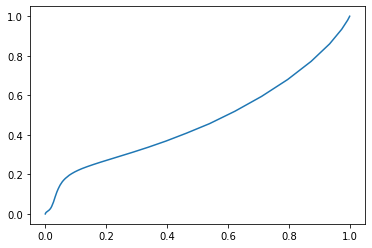

In [31]:
plt.plot(bkg_fpr,bkg_tpr,label='Bkg NFlowVAE-Planar')
